In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
class FourierLayer1d(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, modes, seed = 123):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        
        self.scale = (1 / (in_channels * out_channels))
        
        
        #  The kernel parametrization
        self.kernel = torch.nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes, dtype = torch.cfloat)
        )
        
        self.Linear = torch.nn.Conv1d(in_channels, out_channels, 1)
        
    def cmul(self, x, w):
        """
        x : Tensor of size (i, j, k)
        w : Tensor of size (j, l, k)
        
        return a Tensor of size (i, l, k) which present the product of x and w along the axis j.
        """
        return torch.einsum("ijk, jlk -> ilk", x, w)

    def forward(self, v):
        
        """
        v : Tensor of size (b, d, n) where b is the batch size, d is the dimension of the output of the function v and 
            n is the number of grid points where v is evaluated.
        """
        
        b, d, n  = v.shape
        Nyquist_frequency = (n // 2) + 1
        
        # Compute the fast Fourier transform of x
        Fv = torch.fft.rfft(v)
        
        # Compute the product of the kernel parametrisation and the relevant Fourier modes of Fv. 
        Prod = torch.zeros(b, self.out_channels, Nyquist_frequency, device = v.device, dtype = torch.cfloat)
        Prod[:, :, : self.modes] = self.cmul(Fv[:, :, : self.modes], self.kernel)
        
        # Compute the inverse of fast Fourier transform of product
        IFv = torch.fft.irfft(Prod, n = n)
        
        return self.Linear(v) + IFv

In [5]:
class FNO1d(torch.nn.Module):
    
    def __init__(self, layers_dim, modes, seed = 123):
        
        super().__init__()
        
        self.n_features = layers_dim[0]
        self.lifting_dim = layers_dim[1]
        self.projection_dim = layers_dim[-1]
        
        self.FourierLayers_dim = layers_dim[1:]
        self.FourierLayers_modes = modes
        
        self.Lifting = torch.nn.Linear(self.n_features, self.lifting_dim)
        
        self.FourierLayers = self.creat_FourierLayers(
            self.FourierLayers_dim, self.FourierLayers_modes
        )
        
        self.Projection = torch.nn.Sequential(
            torch.nn.Linear(self.projection_dim, 2* self.projection_dim), 
            torch.nn.GELU(),
            torch.nn.Linear(2* self.projection_dim, 1)
        )
        
        self.init_net(seed)
        
        self.activation = torch.nn.GELU()
        self.padding = 9
        
        
    def creat_FourierLayers(self, layers_dim : list, modes : list):
        layers = torch.nn.ModuleList()
        dim = layers_dim[0]
        for i, hdim in enumerate(layers_dim[1:]) :
            layer = FourierLayer1d(dim, hdim, modes[i])
            layers.append(layer)
            dim = hdim
        return layers

    def init_net(self, seed):
        torch.manual_seed(seed)
        
        for p in self.parameters():
            try:
                torch.nn.init.xavier_uniform_(p)
            except:
                torch.nn.init.constant_(p, 0)
    
    
    def forward(self, x):
        
        x = self.Lifting(x)
        x = x.permute(0, 2, 1)
        
        x = torch.nn.functional.pad(x, [0, self.padding])
        
        for idx, layer in enumerate(self.FourierLayers) :
            x = self.activation(layer(x))
            
        x = x[..., : -self.padding]
        
        x = x.permute(0, 2, 1)
        x = self.Projection(x)
        
        return x

In [6]:
layers_dim = [1, 10, 10, 10, 10]
modes = 3* [10]

In [7]:
model = FNO1d(layers_dim, modes).to(device)

# Dataset

In [8]:
Dmin = 0.1
Dmax = 2

num_D = 1000

In [9]:
D = (Dmax - Dmin)* np.random.rand(num_D, 1) + Dmin

In [10]:
def chaleur(nx, D) :
    
    dx = 1/(nx - 1)
    A = -2 * np.eye(nx - 2) + np.eye(nx - 2, k = -1) + np.eye(nx - 2, k = 1)
    b = - (dx**2 / D)* np.ones(nx - 2)
    
    u = np.linalg.solve(A, b)
    
    return np.linspace(0, 1, nx), np.hstack([0, u, 0])

In [11]:
nx = 100

In [12]:
U = []

for d in D : 
    x, u = chaleur(nx, d)
    U.append(u)
    
U = np.stack(U)

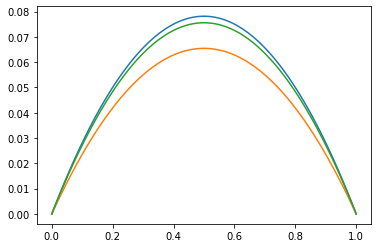

In [13]:
plt.plot(x, U[0, :])
plt.plot(x, U[1, :])
plt.plot(x, U[2, :])

plt.show()

In [14]:
D = torch.Tensor(D).to(device)
U = torch.Tensor(U).to(device)

In [15]:
D = D.repeat(1, nx).unsqueeze(-1)

# Model

In [16]:
def loss_fn(x, y = 0):
    return torch.square(y - x).mean()

In [17]:
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [18]:
log_train = []

In [19]:
num_epochs = 10000

In [20]:
%%time

loading_bar = tqdm(range(num_epochs + 1), colour = 'blue')

for ep in loading_bar :
    
    """
    with torch.no_grad():
        U_val_pred = model(D_val)
        loss_val = loss_fn(U_val_pred, U_val)
        log_val.append(loss_val.item())
    """
    
    U_train_pred = model(D).squeeze(-1)
    
    loss = loss_fn(U_train_pred, U)
    
    loss.backward()

    optimizer.step()

    optimizer.zero_grad()
    
    log_train.append(loss.item())
    
    loading_bar.set_description('training loss : %.2e'%(log_train[-1]))

training loss : 2.50e-08: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10001/10001 [00:59<00:00, 167.30it/s]

CPU times: user 59.1 s, sys: 1.12 s, total: 1min
Wall time: 59.8 s


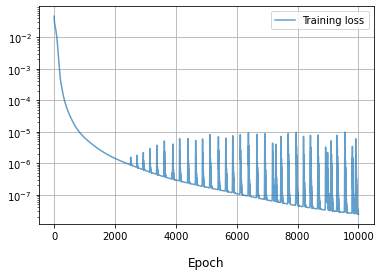

In [21]:
fig, ax = plt.subplots(1, 1)

ax.grid(True)
ax.set_yscale('log')
ax.set_xlabel('Epoch', fontsize = 12, labelpad=15)
ax.plot(log_train, label = 'Training loss', alpha=.7)
#ax.plot(log_val, label = 'Validation loss', alpha=.7)

ax.legend()
plt.show()

In [23]:
pred = model(D).detach().cpu()

In [24]:
pred = pred.squeeze(-1)

In [25]:
pred.shape

torch.Size([1000, 100])

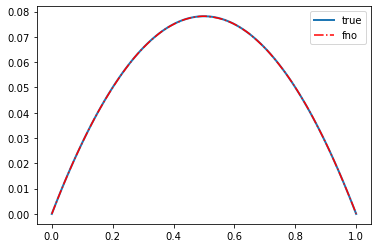

In [27]:
i = 0

plt.plot(x, U[i, :].detach().cpu(), lw = 2, label = 'true')
plt.plot(x, pred[i, :], 'r-.', label = 'fno')


plt.legend()
plt.show()

In [40]:
s = 0

for p in model.parameters() :
    s += p.numel()

In [41]:
s

14181

In [29]:
model

FNO1d(
  (activation): GELU(approximate='none')
  (Lifting): Linear(in_features=1, out_features=20, bias=True)
  (fl0): FourierLayer1d(
    (Linear): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  )
  (fl1): FourierLayer1d(
    (Linear): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  )
  (fl2): FourierLayer1d(
    (Linear): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  )
  (Projection): Sequential(
    (0): Linear(in_features=20, out_features=40, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=40, out_features=1, bias=True)
  )
)

In [33]:
for n, p in model.named_parameters() :
    print(n, '\t :', p.shape)

Lifting.weight 	 : torch.Size([20, 1])
Lifting.bias 	 : torch.Size([20])
fl0.kernel 	 : torch.Size([20, 20, 10])
fl0.Linear.weight 	 : torch.Size([20, 20, 1])
fl0.Linear.bias 	 : torch.Size([20])
fl1.kernel 	 : torch.Size([20, 20, 10])
fl1.Linear.weight 	 : torch.Size([20, 20, 1])
fl1.Linear.bias 	 : torch.Size([20])
fl2.kernel 	 : torch.Size([20, 20, 10])
fl2.Linear.weight 	 : torch.Size([20, 20, 1])
fl2.Linear.bias 	 : torch.Size([20])
Projection.0.weight 	 : torch.Size([40, 20])
Projection.0.bias 	 : torch.Size([40])
Projection.2.weight 	 : torch.Size([1, 40])
Projection.2.bias 	 : torch.Size([1])


In [26]:
test = torch.nn.Linear(3, 4)

In [48]:
t = torch.rand(5, 4, 3)

In [29]:
test(t).shape

torch.Size([5, 4, 4])

In [94]:
T = torch.rand(3, 2, 2)
pad = (0, 1, 0, 0)

In [95]:
T

tensor([[[0.7336, 0.0588],
         [0.7975, 0.3971]],

        [[0.1294, 0.9052],
         [0.5018, 0.6025]],

        [[0.9029, 0.1537],
         [0.1833, 0.2666]]])

In [96]:
T = torch.nn.functional.pad(T, pad)

In [97]:
T

tensor([[[0.7336, 0.0588, 0.0000],
         [0.7975, 0.3971, 0.0000]],

        [[0.1294, 0.9052, 0.0000],
         [0.5018, 0.6025, 0.0000]],

        [[0.9029, 0.1537, 0.0000],
         [0.1833, 0.2666, 0.0000]]])

In [98]:
T.shape

torch.Size([3, 2, 3])

In [22]:
model(D[0].unsqueeze(0))

torch.Size([1, 20, 100])
torch.Size([1, 20, 109])
torch.Size([1, 20, 109])
torch.Size([1, 20, 100])


tensor([[[0.0068],
         [0.0070],
         [0.0071],
         [0.0071],
         [0.0071],
         [0.0070],
         [0.0070],
         [0.0070],
         [0.0069],
         [0.0070],
         [0.0070],
         [0.0070],
         [0.0070],
         [0.0070],
         [0.0070],
         [0.0070],
         [0.0069],
         [0.0069],
         [0.0068],
         [0.0068],
         [0.0067],
         [0.0067],
         [0.0067],
         [0.0067],
         [0.0067],
         [0.0066],
         [0.0066],
         [0.0066],
         [0.0066],
         [0.0066],
         [0.0066],
         [0.0065],
         [0.0065],
         [0.0065],
         [0.0065],
         [0.0064],
         [0.0064],
         [0.0063],
         [0.0063],
         [0.0062],
         [0.0062],
         [0.0063],
         [0.0063],
         [0.0064],
         [0.0065],
         [0.0066],
         [0.0067],
         [0.0067],
         [0.0067],
         [0.0068],
         [0.0068],
         [0.0067],
         [0.

# Fourier pb

In [129]:
x = torch.linspace(-1, 1, 6)
x.shape

torch.Size([6])

In [130]:
f = x**2
f.shape

torch.Size([6])

In [131]:
Ff = torch.fft.rfft(f)
print(Ff.shape)

print(f)
print(torch.fft.irfft(Ff))

torch.Size([4])
tensor([1.0000, 0.3600, 0.0400, 0.0400, 0.3600, 1.0000])
tensor([1.0000, 0.3600, 0.0400, 0.0400, 0.3600, 1.0000])


In [132]:
pad = 9
fp = torch.nn.functional.pad(f, [0, pad])
print(fp.shape)
Ffp = torch.fft.rfft(fp)
print(Ffp.shape)
iFfp = torch.fft.irfft(Ffp)
print(iFfp.shape)
print(iFfp[..., : -pad])

torch.Size([15])
torch.Size([8])
torch.Size([14])
tensor([1.0434, 0.3291, 0.0703, 0.0011, 0.7190])


In [119]:
pad = 2
fp = torch.nn.functional.pad(f, [0, pad])

In [81]:
Ffp = torch.fft.rfft(fp)
Ffp.shape

torch.Size([4])

In [68]:
Ff.real

tensor([2.5000, 1.1840, 0.0660])

In [69]:
Ffp.real

tensor([2.5000, 0.0297, 1.7237, 0.4966])

ValueError: x and y must have same first dimension, but have shapes torch.Size([5]) and torch.Size([7])

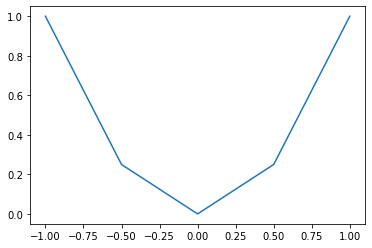

In [59]:
plt.plot(x, f)
plt.plot(x, fp)

In [44]:
x = torch.nn.functional.pad(x, [0, pad])

In [45]:
torch.fft.rfft(x)

tensor([[ 1.2116+0.0000j,  0.3583-0.8532j, -0.4949+0.0000j],
        [ 1.5786+0.0000j,  0.9213-0.6573j,  0.2640+0.0000j]])

In [37]:
x.shape

torch.Size([2, 4])

In [163]:
x = torch.rand(2, 3, 10)

In [164]:
torch.fft.rfft(x).shape

torch.Size([2, 3, 6])